In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

from matplotlib import cm
from skimage import io
from math import sqrt

In [7]:
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from skimage.exposure import equalize_adapthist


def apply_canny(image, sigma, low_threshold, high_threshold):
    return canny(image, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

def apply_exposure(image):
    return equalize_adapthist(image)

def apply_hough(image, threshold, line_length, line_gap):
    return probabilistic_hough_line(image, threshold=threshold, line_length=line_length, line_gap=line_gap)

def compare_point(p0, p1, threshold):
    return p0[1] < threshold and p1[1] > threshold

def count_lines(lines, height):
    count = 0
    threshold = height/2
    for line in lines:
        p0, p1 = line
        if compare_point(p0, p1, threshold) or compare_point(p1, p0, threshold):
            count += 1
    
#     print(f"Input lines = {len(lines)}. After filtering = {count}")
    return (count - 1)

def experiment(image_path, sigma=4.0, low_threshold=0.1, high_threshold=0.3, threshold=5, line_length=150, line_gap=5):
    img =  io.imread(image_path, as_gray=True)

    image_equalized = apply_exposure(img)
    edges = apply_canny(image_equalized, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
    lines = apply_hough(edges, threshold=threshold, line_length=line_length, line_gap=line_gap)
    
    return count_lines(lines, img.shape[0])

In [8]:
def custom_plot(images, lines, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images + 1, figsize=(15, 5), sharex=True, sharey=True)
    ax = axes.ravel()
    
    for i in range(num_images):
        ax[i].imshow(images[i], cmap=cm.gray)
        ax[i].set_title(titles[i])
    
    
    
    lines.sort()
    
    ax[-1].imshow(edges * 0)
    for line in lines:
        p0, p1 = line
        ax[-1].plot((p0[0], p1[0]), (p0[1], p1[1]))

    ax[-1].set_xlim((0, images[0].shape[1]))
    ax[-1].set_ylim((images[0].shape[0], 0))
    ax[-1].set_title(titles[-1])
    
    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()

In [9]:
sigma_values = [3.5, 4.0, 4.5, 5.0]
line_length_values = [100, 150, 200]
line_gap_values = [5, 10]

def generate_param_set(sigma_values, line_length_values, line_gap_values):
    param_set = []
    for s in sigma_values:
        for ll in line_length_values:
            for lg in line_gap_values:
                param_set.append({"sigma": s, "low_threshold": 0.1, "high_threshold": 0.3, "threshold": 5, "line_length": ll, "line_gap": lg})
    return param_set

param_set = generate_param_set(sigma_values, line_length_values, line_gap_values)

In [10]:
def get_ground_truth_key(path):
    return int(path.split('/')[-1].split('.')[0])

dataset_path = "../dataset/*"
ground_truth_path = 'book_count.csv'
def run_experiments(dataset_path, ground_truth_path, param_set):
    
    
    num_images = len(glob.glob(dataset_path))
    
    ground_truth = pd.read_csv(ground_truth_path)
    ground_truth_counter = ground_truth.set_index('name').T.to_dict('list')
    for param_idx, params in enumerate(param_set):
        
        mae_counter = 0
        rmse_counter = 0
        counter = 0
        
        print("===============================================")
        print(f"Begin experiment. Parameters Index={param_idx}")
        for path in sorted(glob.glob(dataset_path)):
            key =  get_ground_truth_key(path)
            original_count = ground_truth_counter.get(key, [-1])[0]
            if original_count != -1:
                experiment_count = experiment(path, **params)
                diff = original_count - experiment_count
                mae_counter += abs(diff)
                rmse_counter += diff ** 2
                counter += 1
            
            if counter % 10 == 0:
                print(f"Done {counter}. Left {num_images - counter} images")
    #         print(path, key, ground_truth_counter.get(key, [-1])[0], experiment_count)
    #         count = experiment(path)

        print(f"Parameter Index={param_idx}, MAE={mae_counter/counter}, RMSE={sqrt(rmse_counter/counter)}")
        print("===============================================")
        

run_experiments(dataset_path, ground_truth_path, param_set)

Begin experiment. Parameters Index=0
Done 10. Left 90 images
Done 20. Left 80 images
Done 30. Left 70 images
Done 40. Left 60 images
Done 50. Left 50 images
Done 60. Left 40 images
Done 70. Left 30 images
Done 80. Left 20 images
Done 90. Left 10 images
Parameter Index=0, MAE=12.787878787878787, RMSE=17.346149108343585
Begin experiment. Parameters Index=1
Done 10. Left 90 images
Done 20. Left 80 images
Done 30. Left 70 images
Done 40. Left 60 images
Done 50. Left 50 images
Done 60. Left 40 images
Done 70. Left 30 images
Done 80. Left 20 images
Done 90. Left 10 images
Parameter Index=1, MAE=12.090909090909092, RMSE=16.321578949168472
Begin experiment. Parameters Index=2
Done 10. Left 90 images
Done 20. Left 80 images
Done 30. Left 70 images
Done 40. Left 60 images
Done 50. Left 50 images
Done 60. Left 40 images
Done 70. Left 30 images
Done 80. Left 20 images
Done 90. Left 10 images
Parameter Index=2, MAE=16.87878787878788, RMSE=21.154315174570186
Begin experiment. Parameters Index=3
Done

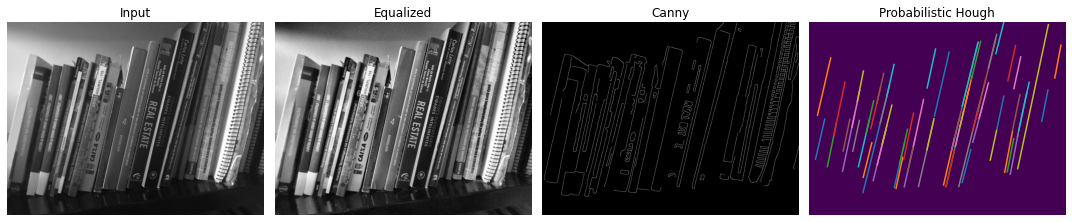

Input lines = 62. After filtering = 23


23

In [37]:
img =  io.imread('../dataset/50.jpg', as_gray=True)
sigma=4.0
low_threshold=0.1
high_threshold=0.3
threshold=5
line_length=150
line_gap=5

image_equalized = apply_exposure(img)
edges = apply_canny(image_equalized, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
lines = apply_hough(edges, threshold=threshold, line_length=line_length, line_gap=line_gap)

custom_plot([img, image_equalized, edges], lines, ['Input', 'Equalized', 'Canny', 'Probabilistic Hough'])
count_lines(lines, img.shape[0])


